In [96]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import time
import math
from sklearn.model_selection import train_test_split
import torch.optim as optim
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import os

In [97]:
# Import the data 
def load_and_prepare_data(file_path):
    """
    Load energy prices data from a CSV file, ensure chronological order, and convert 'Date' to datetime.
    """
    df = pd.read_csv(file_path)
    df['date'] = pd.to_datetime(df['date'])
    df.sort_values('date', inplace=True)
    df.reset_index(drop=True, inplace=True)
    df = pd.DataFrame(df)
    return df

os.getcwd()
data = load_and_prepare_data('../../data/Final_data/final_data.csv')

In [98]:
data

,date,Day_ahead_price,BEV_vehicles,Biomass (GWh),Hard Coal (GWh),Hydro (GWh),Lignite (GWh),Natural Gas (GWh),Nuclear (GWh),Oil_price (EUR),Other (GWh),Pumped storage generation (GWh),Solar (GWh),Solar_radiation,TTF_gas_price (EUR/MWh),Temperature,Wind offshore (GWh),Wind onshore (GWh),Wind_speed,net_total_export_import (GWh)
0,2012-01-01,18.1896,6,98.605,108.454,51.011,325.337,188.811,250.979,98.99,54.040,19.314,6.263,14.75,21.1000,8.39,3.404,235.467,4.95,54.662
1,2012-01-02,33.8188,6,98.605,222.656,51.862,343.168,229.293,258.671,99.39,54.166,28.892,6.312,15.12,20.0000,7.41,3.350,231.772,5.00,-64.477
2,2012-01-03,35.0263,6,98.605,162.204,48.851,336.773,241.297,271.495,99.79,53.518,21.072,24.226,31.88,20.9000,5.23,7.292,504.484,7.77,-35.078
3,2012-01-04,32.1633,6,98.605,189.633,47.101,323.976,252.289,270.613,102.48,52.194,28.300,14.157,25.21,21.4000,4.78,7.828,541.528,8.04,22.924
4,2012-01-05,20.3500,6,98.605,175.733,45.854,327.502,259.018,287.555,103.24,52.179,31.887,4.728,13.46,21.3000,4.23,8.280,572.819,9.98,35.618
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4434,2024-02-25,61.0938,947,123.683,48.501,58.671,193.697,255.124,0.000,74.73,60.627,13.565,169.216,97.58,23.7625,4.52,29.879,278.787,3.43,-36.930
4435,2024-02-26,66.2683,947,124.810,69.146,58.444,281.177,289.764,0.000,74.60,59.810,12.231,110.504,73.25,23.9000,4.96,62.336,239.555,3.12,-198.686
4436,2024-02-27,73.8362,947,124.989,103.379,59.181,351.355,354.042,0.000,75.61,67.170,23.753,85.584,58.12,24.8300,4.53,16.951,131.761,3.11,-209.332
4437,2024-02-28,71.8213,947,125.068,93.416,58.160,350.348,338.216,0.000,76.07,65.375,19.042,106.330,66.00,24.8000,3.69,68.585,76.355,2.46,-206.956


In [80]:
# Selecting only the price column for scaling
price_data = data['Day_ahead_price'].values.reshape(-1, 1)

# Scaling the price data
scaler = MinMaxScaler()
price_data_scaled = scaler.fit_transform(price_data)
data['Day_ahead_price_scaled'] = price_data_scaled

In [81]:
price_data_scaled.shape

(4439, 1)

In [94]:
# Normalize the data
# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data.drop(columns=['date']))

def create_sequences(input_data, labels, seq_length):
    xs, ys = [], []
    for i in range(len(input_data) - seq_length):
        x = input_data[i:(i + seq_length)]
        y = labels[i + seq_length]  # label corresponding to the day immediately after the sequence
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

seq_length = 10
X, y = create_sequences(data[['Day_ahead_price_scaled']].values, data['Day_ahead_price'].values, seq_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


In [95]:
# After creating sequences, check the alignment of inputs and labels
print("Check sequence alignment:")
for i in range(3):
    print(f"X[{i}] last day price scaled: {X[i][-1]}, Corresponding y[{i}]: {y[i]}")


Check sequence alignment:
X[0] last day price scaled: [0.13571561], Corresponding y[0]: 47.8333
X[1] last day price scaled: [0.13843935], Corresponding y[1]: 43.1037
X[2] last day price scaled: [0.13218584], Corresponding y[2]: 36.6929


In [83]:
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, output_dim):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim  # Save hidden_dim as instance attribute
        self.num_layers = num_layers  # Save num_layers as instance attribute
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state and cell state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).requires_grad_()
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])  # taking the last time step's output
        return out

# Now use the correct input dimension when creating your model instance
input_dim = 19  # The number of input features
hidden_dim = 50
num_layers = 2
output_dim = 1
model = LSTMModel(input_dim, hidden_dim, num_layers, output_dim)



In [84]:
# Training the model
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 5

def train_model(model, X_train, y_train, num_epochs):
    model.train()
    for epoch in range(num_epochs):
        X_train_t = torch.tensor(X_train).float()
        y_train_t = torch.tensor(y_train).float().view(-1, 1)
        
        optimizer.zero_grad()
        outputs = model(X_train_t)
        loss = criterion(outputs, y_train_t)
        
        loss.backward()
        optimizer.step()
        print(f'Epoch {epoch+1} Loss {loss.item()}')

train_model(model, X_train, y_train, num_epochs)


Epoch 1 Loss 0.010869279503822327
Epoch 2 Loss 0.008292029611766338
Epoch 3 Loss 0.007126167882233858
Epoch 4 Loss 0.007101540453732014
Epoch 5 Loss 0.00749870203435421


In [85]:
# Evaluating the model
model.eval()
X_test_t = torch.tensor(X_test).float()
with torch.no_grad():
    predicted = model(X_test_t)
    predicted = predicted.view(-1, 1)
    # Inverse transform to original price scale
    predicted_prices = scaler.inverse_transform(predicted.cpu().numpy())
    print(predicted_prices)


[[ 5.16256714e+00]
 [ 3.76488256e+00]
 [ 3.86073303e+00]
 [ 3.73421144e+00]
 [ 4.54795027e+00]
 [ 6.12347460e+00]
 [ 7.85976362e+00]
 [ 8.02317715e+00]
 [ 8.30890942e+00]
 [ 8.28430176e+00]
 [ 7.91301394e+00]
 [ 6.82501030e+00]
 [ 5.02098274e+00]
 [ 3.80540919e+00]
 [ 3.01634550e+00]
 [ 2.32409620e+00]
 [ 3.20446301e+00]
 [ 4.15461874e+00]
 [ 4.11692667e+00]
 [ 4.62912226e+00]
 [ 5.76506853e+00]
 [ 5.51720333e+00]
 [ 4.51906586e+00]
 [ 4.12616253e+00]
 [ 4.64921618e+00]
 [ 6.32136869e+00]
 [ 8.27550030e+00]
 [ 9.33716583e+00]
 [ 8.82259274e+00]
 [ 7.66908789e+00]
 [ 7.20230484e+00]
 [ 7.00539637e+00]
 [ 7.19988728e+00]
 [ 6.97664118e+00]
 [ 6.89444399e+00]
 [ 6.36766529e+00]
 [ 5.69194889e+00]
 [ 5.53606892e+00]
 [ 4.47909689e+00]
 [ 3.04557395e+00]
 [ 2.14219403e+00]
 [ 2.44335437e+00]
 [ 3.09262037e+00]
 [ 4.02603483e+00]
 [ 4.12035275e+00]
 [ 4.38525248e+00]
 [ 4.08979416e+00]
 [ 3.11571240e+00]
 [ 2.92325020e+00]
 [ 1.96788204e+00]
 [ 7.08423138e-01]
 [ 2.62551218e-01]
 [-3.8873761

First 5 predicted prices: [5.162567  3.7648826 3.860733  3.7342114 4.5479503]
First 5 actual prices: [194.25878822 194.25878822 194.25878822 194.25878822 199.88443312]


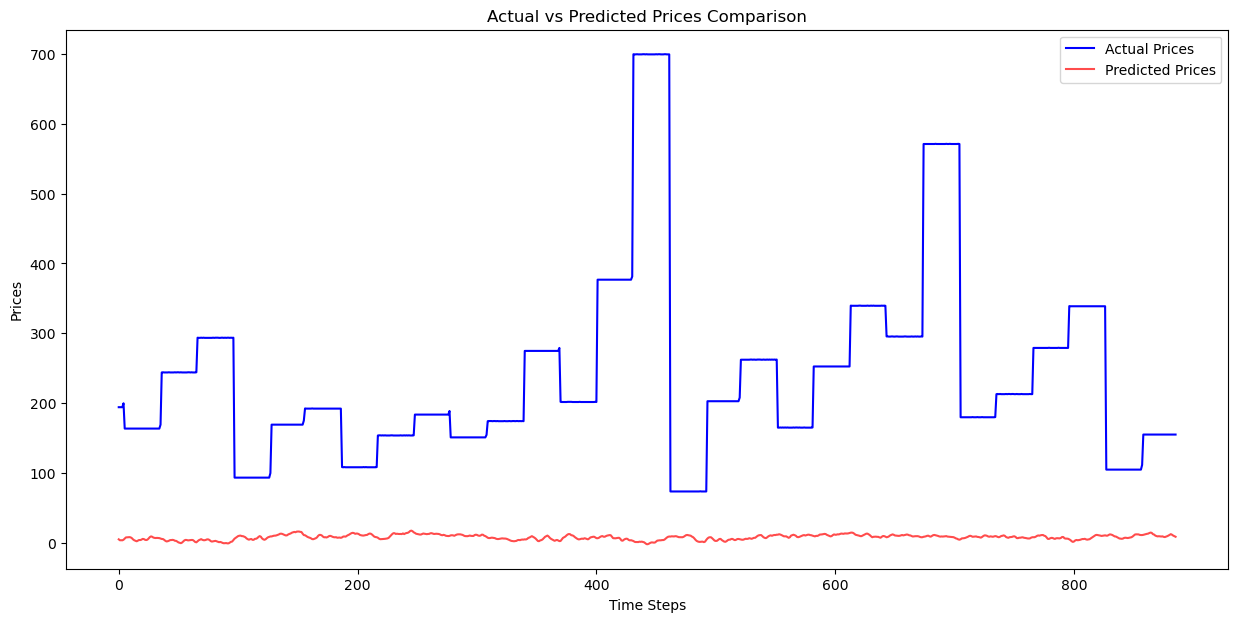

In [93]:
# Assuming you have loaded and prepared data, defined, and trained your model

# Evaluate and predict
model.eval()
X_test_t = torch.tensor(X_test).float()
with torch.no_grad():
    predicted = model(X_test_t)
    predicted = predicted.view(-1, 1)
    predicted_prices = scaler.inverse_transform(predicted.cpu().numpy())

# Debug by examining the first few predicted and actual values
print("First 5 predicted prices:", predicted_prices.flatten()[:5])
print("First 5 actual prices:", actual_prices.flatten()[:5])

# Plotting for a closer look
plt.figure(figsize=(15, 7))
plt.plot(actual_prices, label='Actual Prices', color='blue')
plt.plot(predicted_prices, label='Predicted Prices', color='red', alpha=0.7)
plt.title('Actual vs Predicted Prices Comparison')
plt.xlabel('Time Steps')
plt.ylabel('Prices')
plt.legend()
plt.show()


In [92]:
actual_prices

array([[194.25878822],
       [194.25878822],
       [194.25878822],
       [194.25878822],
       [199.88443312],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [163.65527998],
       [169.28092487],
       [243.98948911],
       [244.21451491],
       [243.98948911],
       [243.98948911],
       [243.98948911],
       [243.98948911],
       [244.21451491],
       [243

In [90]:
mse = mean_squared_error(actual_prices, predicted_prices)
mae = mean_absolute_error(actual_prices, predicted_prices)
r2 = r2_score(actual_prices, predicted_prices)

print("Mean Squared Error (MSE):", mse)
print("Mean Absolute Error (MAE):", mae)
print("R-squared:", r2)


Mean Squared Error (MSE): 71174.23802569251
Mean Absolute Error (MAE): 230.6405827934285
R-squared: -3.022654760772088
